<a href="https://colab.research.google.com/github/Haibei1115/Subglacial-Discharge/blob/main/Evolve_Channel_Shape_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from dataclasses import dataclass
from typing import Callable, Dict, List, Tuple, Optional
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline
from scipy.optimize import brentq

# =========================
# Model parameters (dimensionless)
# =========================
@dataclass
class Params:
    A: float = 0.05       # entrainment
    F: float = 0.25       # densimetric Froude number
    C: float = 0.10       # interfacial drag
    S: float = 0.00       # bed-slope term
    D: float = 0.05       # vertical heat exchange with top layer/ice
    Gamma_hat: float = 0.01  # salinity correction coefficient on freezing temperature
    M: float = 1.0        # dimensionless melt parameter
    Sm_S0: float = 0.0    # upstream salinity (s1(x_l)=0 here)

# =========================
# Numerics & domain
# =========================
@dataclass
class Numerics:
    x_min: float = -6.0
    x_max: float =  6.0
    Nx: int = 600                   # spatial resolution for h(x,t)
    t_steps: int = 60               # number of time steps
    dt: float = 0.02                # time step
    max_ivp_step: float = 0.1       # max step for solve_ivp
    rtol: float = 1e-7              # relative tolerance for solve_ivp
    atol: float = 1e-9               # absolute tolerance for solve_ivp
    den_tol: float = 1e-6           # Δ ≈ 0 tolerance
    eps_q: float = 1e-8
    eps_h: float = 1e-5
    eps_s: float = 1e-8

import numpy as np

# =========================
# Geometry helper (Cubic)
# =========================
class Geometry:
    # Smooth interpolant for h(x) and dh/dx, updated each time step.
    def __init__(self, x: np.ndarray, h: np.ndarray):
        self.update(x, h)
    def update(self, x: np.ndarray, h: np.ndarray):
        self.x = x
        self.h = h
        self.spline = CubicSpline(x, h, bc_type='natural')

    def h_of(self, x: float) -> float:
        return float(self.spline(x))
    def dhdx_of(self, x: float) -> float:
        return float(self.spline(x, 1))


# =========================
# Core expressions
# =========================
def delta_den(q1, h1, h_tot, s1, F2):
    """ Hydraulic-control denominator Δ. """
    om_q1 = 1.0 - q1
    hm_h1 = h_tot - h1
    return -F2*q1*q1/h1**3 - F2*om_q1*om_q1/hm_h1**3 + (1.0 - s1)

def regularity_E(q1, h1, h_tot, dhdx, s1, A, F2, C, S):
    """ Regularity condition that must vanish at xc so dh1/dx stays finite when Δ→0. """
    om_q1 = 1.0 - q1
    hm_h1 = h_tot - h1
    dU = q1/h1 - om_q1/hm_h1
    term1 = A*F2*(q1/h1**2 + om_q1/hm_h1**2)*dU
    term2 = (C*h_tot/hm_h1 + A)*F2/h1 * dU**2
    term3 = F2*(q1**2/h1**3 - om_q1**2/hm_h1**3)
    term4 = (1.0 - s1)*(dhdx + S)  # s2 = 1
    return term1 + term2 + term3 - term4

# =========================
# First system RHS and event for Δ ≈ 0
# =========================
def make_rhs_first_system(geom: Geometry, P: Params, N: Numerics):
    F2 = P.F*P.F
    def rhs(x, y):
        # y = [q1, h1, s1]; geometry is evaluated at scalar x
        q1, h1, s1 = y
        h = geom.h_of(x)
        dhdx = geom.dhdx_of(x)

        # safety clamps
        q1 = max(q1, N.eps_q)
        h1 = np.clip(h1, N.eps_h, h - N.eps_h)

        om_q1 = 1.0 - q1
        hm_h1 = h - h1
        dU = q1/h1 - om_q1/hm_h1

        dq1dx = P.A * dU

        num = ( P.A*F2*(q1/h1**2 + om_q1/hm_h1**2)*dU
              + (P.C * h/hm_h1 + P.A)*F2/h1*dU**2
              + F2*(q1**2/h1**3 - om_q1**2/hm_h1**3)
              - (1.0 - s1)*(dhdx + P.S) )

        den = delta_den(q1, h1, h, s1, F2)
        dh1dx = - num / den

        ds1dx = P.A*(1.0 - s1)*dU / q1

        return [dq1dx, dh1dx, ds1dx]
    def event_delta(x, y):
        q1, h1, s1 = y
        h = geom.h_of(x)
        # safety
        q1 = max(q1, N.eps_q)
        h1 = np.clip(h1, N.eps_h, h - N.eps_h)
        return delta_den(q1, h1, h, s1, P.F*P.F) - N.den_tol
    event_delta.terminal = True
    event_delta.direction = 0
    return rhs, event_delta

# =========================
# Temperature ODE
# =========================
def make_rhs_theta(geom: Geometry, q1_fun: Callable, h1_fun: Callable, s1_fun: Callable,
                   P: Params, N: Numerics):
    def rhs_t(x, theta1):
        # safety clamps
        q1 = max(float(q1_fun(x)), N.eps_q)
        h1 = np.clip(float(h1_fun(x)), N.eps_h, geom.h_of(x) - N.eps_h)
        s1 = float(s1_fun(x))

        om_q1 = 1.0 - q1
        hm_h1 = geom.h_of(x) - h1
        dU = q1/h1 - om_q1/hm_h1

        dthdx = ( P.A*dU*(1.0 - theta1)/q1
                  - P.D * (q1/h1) * (theta1 + P.Gamma_hat*s1)/q1 )  # theta2 = 1
        return dthdx
    return rhs_t

# =========================
# Integrate first system from a guessed xl; return residual E(x_c) and solution
# =========================
def integrate_first_system_from(xl: float, geom: Geometry, P: Params, N: Numerics,
                                x_hi: float) -> Tuple[float, float, Optional[solve_ivp]]:
    rhs, evt = make_rhs_first_system(geom, P, N)
    # BCs at x=xl: q1=1, h1=h(xl), s1=0
    h_l = geom.h_of(xl + 1e-8)
    y0 = [1.0 + N.eps_q, h_l - N.eps_h, 0.0 + N.eps_s]
    sol = solve_ivp(rhs, (xl + 1e-8, x_hi), y0,
                    method="Radau", rtol=N.rtol, atol=N.atol,
                    max_step=N.max_ivp_step, events=[evt], dense_output=True)
    if sol.t_events[0].size:
        x_c = float(sol.t_events[0][0])
        q1_c, h1_c, s1_c = sol.sol(x_c).ravel()

        # x_c  = sol.t_events[0][-1]
        # q1_c, h1_c, s1_c = sol.y_events[0][-1]

        #.ravel() flattens this (3, 1) array into a 1D array (3,), so a float value is assigned to each of q1, h1, s1
        E_c = regularity_E(q1_c, h1_c, geom.h_of(x_c), geom.dhdx_of(x_c),
                           s1_c, P.A, P.F*P.F, P.C, P.S)
        return E_c, x_c, sol
    # no control point hit in domain
    return np.nan, np.nan, None

# =========================
# Shooting for xl (with fallback to min |E| if no sign change)
# =========================
def shoot_for_xl(geom: Geometry, P: Params, N: Numerics,
                 xl_min: float, xl_max: float, n_scan: int,
                 verbose: bool = True) -> Tuple[float,float,Optional[solve_ivp]]:
    def residual(xl):
        E, _, _ = integrate_first_system_from(xl, geom, P, N, N.x_max)
        return E

    # coarse scan
    xl_space = np.linspace(xl_min, xl_max, n_scan)
    E_vals = []
    xc_vals = []
    sols = []
    for xl in xl_space:
        E, xc, sol = integrate_first_system_from(xl, geom, P, N, N.x_max)
        E_vals.append(E if np.isfinite(xc) else np.nan)  # mark NaN if no control pt
        xc_vals.append(xc)
        sols.append(sol)

    E_arr = np.array(E_vals)

    # Try to find a sign change among finite residuals
    finite = np.isfinite(E_arr)
    sign_change_interval = None
    if finite.sum() >= 2:
        xs = xl_space[finite]
        Es = E_arr[finite]
        for i in range(len(xs)-1):
            if Es[i] == 0.0:
                sign_change_interval = (xs[i], xs[i])
                break
            if Es[i]*Es[i+1] < 0:
                sign_change_interval = (xs[i], xs[i+1])
                break

    if sign_change_interval is not None:
        a, b = sign_change_interval
        Ea = residual(a)
        Eb = residual(b)
        mid = 0.5*(a+b)

        def residual_guarded(x):
            E, _, _ = integrate_first_system_from(x, geom, P, N, N.x_max)
            if np.isfinite(E):
                return float(E)
            # Event failed / solver blew up at this probe; keep bracketing alive
            # by returning a finite value with the endpoint sign for the half x is in.
            return Ea if x <= mid else Eb

        # xl_star = brentq(residual, a, b, xtol=1e-6, rtol=1e-6)
        xl_star = brentq(residual_guarded, a, b, xtol=1e-6, rtol=1e-6) - 1e-3 # xl shifted to the left here
        E, xc, sol = integrate_first_system_from(xl_star, geom, P, N, N.x_max)
        if verbose:
            print(f"[shoot] Bracketed root in [{a:.4f},{b:.4f}] -> xl={xl_star:.6f}, E={E:.3e}")
        return xl_star, xc, sol

    # Fallback: choose xl that minimizes |E| among finite residuals
    if finite.any():
        idx = np.nanargmin(np.abs(E_arr[finite]))
        xl_star = xl_space[finite][idx]
        E, xc, sol = integrate_first_system_from(xl_star, geom, P, N, N.x_max)
        if verbose:
            print(f"[shoot] No sign change; fallback to min |E| at xl={xl_star:.6f}, E={E:.3e}")
        return xl_star, xc, sol

    # Worst case: no control point for any guess — return middle guess and warn
    xl_star = 0.5*(xl_min + xl_max)
    E, xc, sol = integrate_first_system_from(xl_star, geom, P, N, N.x_max)
    if verbose:
        print("[shoot] No control point found in scan; returning mid-interval guess "
              f"xl={xl_star:.4f}, E={E:.3e}. You may need to widen the x-domain.")
    return xl_star, xc, sol

# =========================
# Helpers: finite differences for dh/dx on a grid
# =========================
def fd_dhdx(x: np.ndarray, h: np.ndarray) -> np.ndarray:
    dx = x[1]-x[0]
    g = np.zeros_like(h)
    g[1:-1] = (h[2:] - h[:-2])/(2*dx)
    g[0] = (h[1] - h[0])/dx
    g[-1] = (h[-1] - h[-2])/dx
    return g

# =========================
# Advance h by one time step WITH continuity/slope match at xc
# =========================
def advance_h_piecewise(
    x: np.ndarray,
    h: np.ndarray,
    xl: float,
    xc: float,
    rhs_source_on_grid: np.ndarray,
    P: Params,
    N: Numerics
) -> np.ndarray:
    """
    Left  of plume [x <= xl]: dh/dt = 0 -> unchanged.
    Middle (xl, xc): explicit Euler on ∂t h = -(1/M) ∂x h + source.
                     (do NOT update exactly at xl or xc to simplify matching)
    Right of plume (x > xc): set linear ramp matched to updated interior:
                             h(x) = h_mid(xc) + h'_mid(xc) * (x - xc)
    """
    x = np.asarray(x)
    h = np.asarray(h)
    dx = x[1]-x[0]

    # Masks (strict interior for middle to avoid boundary mismatch)
    mask_left  = x <= xl
    mask_mid   = (x > xl) & (x < xc)
    mask_right = x > xc

    # Start with copy
    h_new = h.copy()

    # Middle update
    if np.any(mask_mid):
        dhdx_now = fd_dhdx(x, h)                     # gradient at time t
        h_new[mask_mid] = h[mask_mid] + N.dt * ( - (1.0/P.M) * dhdx_now[mask_mid] + rhs_source_on_grid[mask_mid] )

        # Build spline on the UPDATED interior to get value & slope at xc
        xs_mid = x[mask_mid]
        hs_mid = h_new[mask_mid]

        if len(xs_mid) >= 4:
            mid_spline = CubicSpline(xs_mid, hs_mid, bc_type='natural')
            h_c_new = float(mid_spline(xc))
            slope_c_new = float(mid_spline(xc, 1))
        elif len(xs_mid) >= 2:
            # linear fit if just a couple of points
            coeffs = np.polyfit(xs_mid, hs_mid, 1)
            slope_c_new = float(coeffs[0])
            h_c_new = float(np.polyval(coeffs, xc))
        else:
            # plume too short; fall back to old geometry for slope and value at xc
            h_c_new = float(np.interp(xc, x, h))
            # one-sided slope from left
            i = np.searchsorted(x, xc) - 1
            i = np.clip(i, 1, len(x)-2)
            slope_c_new = (h[i] - h[i-1])/(x[i]-x[i-1])

        # Enforce exact continuity at xc on grid (if xc coincides with a grid node)
        at_xc = np.isclose(x, xc, atol=0.5*dx)
        h_new[at_xc] = h_c_new

        # Right extension: value & slope matched at xc
        h_new[mask_right] = h_c_new + slope_c_new*(x[mask_right] - xc)

    # Floor
    h_new = np.maximum(h_new, 1e-3)
    return h_new

# =========================
# Main time-stepping driver
# =========================
def run_sim(params: Params, numerics: Numerics) -> Dict[str, List]:
    P, N = params, numerics
    x = np.linspace(N.x_min, N.x_max, N.Nx)

    # initial geometry h(x,0)=1
    h = np.ones_like(x)
    geom = Geometry(x, h.copy())

    # storage
    out = {
        "t": [], "xl": [], "xc": [], "intrusion": [],
        "h": [], "q1": [], "h1": [], "s1": [], "theta1": []
    }

    for n in range(N.t_steps+1):
        t = n * N.dt
        # 1) Find xl/xc and q1,h1,s1 for current geometry
        if n == 0:
            # FIRST STEP: rectangular channel, no shooting; choose xl=0
            xl = 0.0
            E, xc, plume = integrate_first_system_from(xl, geom, P, N, N.x_max)
            if plume is None or not np.isfinite(xc):
                raise RuntimeError("Step 0: failed to find control point with rectangular geometry.")
        else:
            # Subsequent steps: shooting to determine xl for current h(x,t)
            # xl_search_min = N.x_min + 0.05*(N.x_max - N.x_min)
            # xl_search_min = N.x_min
            xl_search_min = xl - 10
            # xl_search_max = N.x_max - 0.25*(N.x_max - N.x_min)
            # xl_search_max = N.x_max
            xl_search_max = xl + 10
            xl_0, xc, plume = shoot_for_xl(geom, P, N, xl_search_min, xl_search_max, n_scan=200)
            xl = xl_0 - 1e-3

        # sample solution along x within [xl, xc]
        x_left = max(x[0], xl)
        x_right = min(x[-1], xc)
        if not (np.isfinite(x_left) and np.isfinite(x_right) and (x_left < x_right) and (plume is not None)):
            # plume collapsed or no control point: keep zero fields
            q1_grid = np.zeros_like(x)
            h1_grid = np.zeros_like(x)
            s1_grid = np.zeros_like(x)
            theta_grid = np.zeros_like(x)
        else:
            x_eval = x[(x >= x_left) & (x <= x_right)]
            q1_vals, h1_vals, s1_vals = plume.sol(x_eval)
            # safety clamp
            q1_vals = np.maximum(q1_vals, N.eps_q)
            h_eval_geom = geom.spline(x_eval) # current h
            h1_vals = np.clip(h1_vals, N.eps_h, h_eval_geom - N.eps_h)

            # Interpolants
            q1_fun = CubicSpline(x_eval, q1_vals, bc_type='natural')
            h1_fun = CubicSpline(x_eval, h1_vals, bc_type='natural')
            s1_fun = CubicSpline(x_eval, s1_vals, bc_type='natural')

            # 2) integrate temperature θ1 over [xl, xc]
            rhs_t = make_rhs_theta(geom, q1_fun, h1_fun, s1_fun, P, N)
            t_sol = solve_ivp(rhs_t, (x_left, x_right), [0.0],  # θ1(x_l)=0
                              method="Radau", rtol=N.rtol, atol=N.atol,
                              max_step=N.max_ivp_step, dense_output=True)
            theta_vals = t_sol.sol(x_eval)[0]

            # put fields on full grid; zeros elsewhere
            q1_grid = np.zeros_like(x)
            h1_grid = np.zeros_like(x)
            s1_grid = np.zeros_like(x)
            theta_grid = np.zeros_like(x)

            mask = (x >= x_left) & (x <= x_right)
            q1_grid[mask] = q1_vals
            h1_grid[mask] = h1_vals
            s1_grid[mask] = s1_vals
            theta_grid[mask] = theta_vals

        # store current fields (before updating h)
        out["t"].append(t)
        out["xl"].append(xl)
        out["xc"].append(xc)
        out["intrusion"].append(float(xc - xl) if (np.isfinite(xc) and np.isfinite(xl)) else np.nan)
        out["h"].append(h.copy())
        out["q1"].append(q1_grid.copy())
        out["h1"].append(h1_grid.copy())
        out["s1"].append(s1_grid.copy())
        out["theta1"].append(theta_grid.copy())

        # 3) evolve h(x,t) to h(x,t+dt) using piecewise rule (unless last step)
        if n < N.t_steps:
            if np.isfinite(x_left) and np.isfinite(x_right) and (x_left < x_right):
                rhs_source = np.zeros_like(x)
                mask_mid = (x > x_left) & (x < x_right)
                # RHS inside plume: (1/(1+Gamma_hat)) * (q1/h1)*(theta1 + Gamma_hat*s1)
                if np.any(mask_mid):
                    safe_h1 = np.maximum(h1_grid[mask_mid], N.eps_h)
                    rhs_source[mask_mid] = (1.0/(1.0 + P.Gamma_hat)) * (q1_grid[mask_mid]/safe_h1) * (theta_grid[mask_mid] + P.Gamma_hat*s1_grid[mask_mid])

                # advance with matched extension at xc
                h = advance_h_piecewise(
                    x=x, h=h, xl=xl, xc=xc,
                    rhs_source_on_grid=rhs_source,
                    P=P, N=N
                )
            # refresh geometry for next step
            geom.update(x, h)

    return out




In [ ]:
# =========================
# Quick run & save
# =========================
if __name__ == "__main__":
    # Example parameters; you can use dt=2, t_steps=1 to reproduce your quick test
    P = Params(
        A=0.05, F=0.25, C=0.10, S=0.00,
        D=0.05, Gamma_hat=0.01,
        M=1000.0, Sm_S0=0.0
    )
    N = Numerics(
        x_min=-5.0, x_max=45.0, Nx=500,
        t_steps=10, dt=0.1,
        max_ivp_step=0.1, rtol=1e-7, atol=1e-9,
        den_tol=1e-6, eps_q=1e-8, eps_h=1e-5, eps_s=1e-8
    )

    results = run_sim(P, N)

    from google.colab import files

    # Save results as compressed .npz
    np.savez("simulation_results.npz", **results)

    # Download to your local machine
    files.download("simulation_results.npz")


[shoot] Bracketed root in [7.3869,7.4874] -> xl=7.415410, E=9.340e-01
[shoot] Bracketed root in [7.1632,7.2637] -> xl=7.208418, E=8.845e-01
[shoot] Bracketed root in [6.9562,7.0567] -> xl=7.033094, E=8.244e-01
[shoot] Bracketed root in [6.7808,6.8813] -> xl=6.878088, E=7.899e-01
[shoot] Bracketed root in [6.7263,6.8268] -> xl=6.736870, E=7.210e-01
[shoot] Bracketed root in [6.5851,6.6856] -> xl=6.605556, E=6.291e-01
[shoot] Bracketed root in [6.4538,6.5543] -> xl=6.481825, E=6.335e-01
[shoot] Bracketed root in [6.3301,6.4306] -> xl=6.363103, E=4.710e-01
[shoot] Bracketed root in [6.2113,6.3119] -> xl=6.248462, E=5.573e-01
[shoot] Bracketed root in [6.0967,6.1972] -> xl=6.136440, E=5.175e-01


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

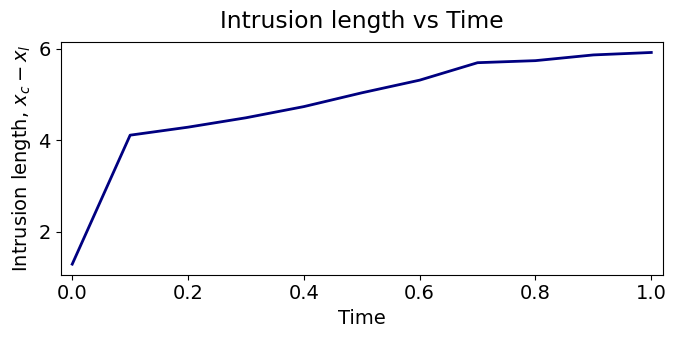

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# Style: set fonts globally to 14
mpl.rcParams.update({'font.size': 14})

# Data
t = np.array(results["t"])
L_intr = np.array(results["intrusion"])

# Figure
fig, ax = plt.subplots(figsize=(7, 3.6))

ax.plot(t, L_intr, color='navy', linewidth=2)

ax.set_xlabel("Time")  # add unit if applicable
ax.set_ylabel(r"Intrusion length, $x_c - x_l$")  # add unit if applicable
ax.set_title("Intrusion length vs Time", pad=10)

# ax.grid(True, linewidth=0.6, alpha=0.6)

# Slight padding on limits for aesthetics
x_pad = 0.02 * (t.max() - t.min()) if t.size > 1 else 1
y_pad = 0.05 * (np.nanmax(L_intr) - np.nanmin(L_intr)) if np.nanmax(L_intr) != np.nanmin(L_intr) else 1
ax.set_xlim(t.min() - x_pad, t.max() + x_pad)
ax.set_ylim(np.nanmin(L_intr) - y_pad, np.nanmax(L_intr) + y_pad)

fig.tight_layout()
plt.show()


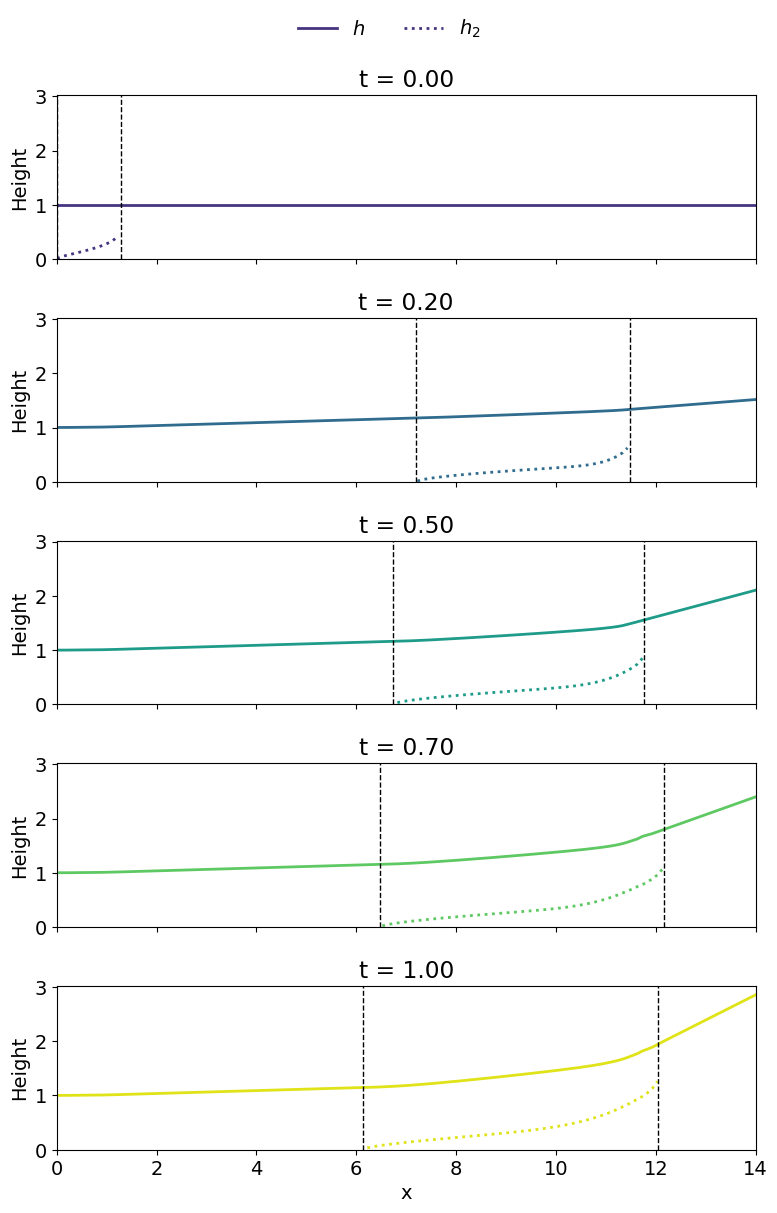

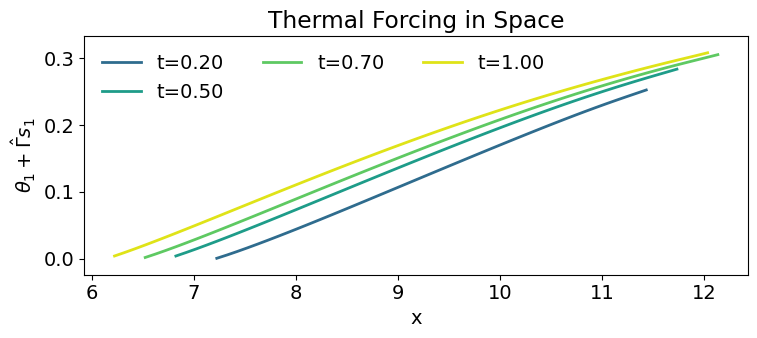

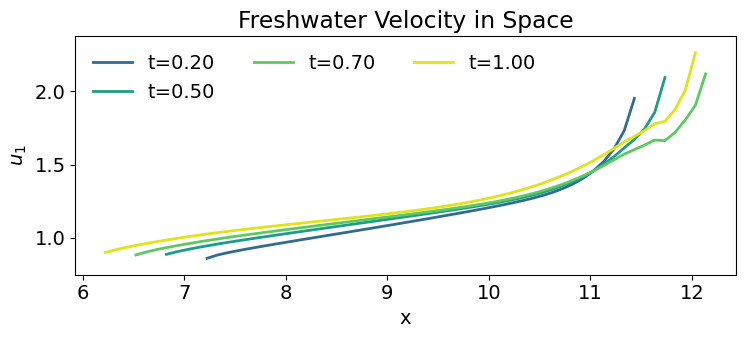

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# --- Global styling ---
mpl.rcParams.update({'font.size': 14})

# --- Shared indices and colors ---
x = np.linspace(N.x_min, N.x_max, N.Nx)
idxs_all = np.linspace(0, N.t_steps, 5, dtype=int)              # 5 snapshots
# Color map across all 5 selected times
palette = plt.cm.viridis(np.linspace(0.15, 0.95, len(idxs_all)))
color_by_idx = {k: c for k, c in zip(idxs_all, palette)}

# ============================================================
# 1) H & H2 (5 subplots, same y-limits, h2 only in [xl, xc])
# ============================================================
# Compute a common y-max across all selected times (based on h)
y_max = 0.0
for k in idxs_all:
    h_k = np.asarray(results["h"][k])
    if h_k.size:
        y_max = max(y_max, np.nanmax(h_k))
y_max = 1.05 * y_max if y_max > 0 else 1.0  # small headroom

fig, axes = plt.subplots(5, 1, figsize=(8, 12), sharex=True)

for ax, k in zip(axes, idxs_all):
    t_k  = results["t"][k]
    h    = np.asarray(results["h"][k])
    h1   = np.asarray(results["h1"][k])
    h2   = h - h1
    xl_k = results["xl"][k]
    xc_k = results["xc"][k]
    c    = color_by_idx[k]

    # h across full domain (solid)
    ax.plot(x, h, '-', color=c, label=r'$h$', linewidth=2)

    # h2 only in (xl, xc) (dotted)
    mask = np.isfinite(xl_k) and np.isfinite(xc_k)
    if mask:
        seg_mask = (x > xl_k) & (x < xc_k)
        if np.any(seg_mask):
            ax.plot(x[seg_mask], h2[seg_mask], ':', color=c, label=r'$h_2$', linewidth=2)

        # verticals
        ax.axvline(xl_k, color='k', linestyle='--', linewidth=1)
        ax.axvline(xc_k, color='k', linestyle='--', linewidth=1)

    # formatting
    ax.set_ylabel("Height")
    ax.set_title(f"t = {t_k:.2f}")
    # ax.grid(True, linewidth=0.6, alpha=0.6)
    ax.set_xlim(0, 14)
    ax.set_ylim(0, y_max/6)

axes[-1].set_xlabel("x")

# single legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.02))

fig.tight_layout(rect=(0, 0, 1, 0.98))
plt.show()

# ============================================================
# 2) (theta1 + Gamma_hat*s1) in plume only, skip t=0
# ============================================================
idxs_no_t0 = [k for k in idxs_all if results["t"][k] > 0]

fig, ax = plt.subplots(figsize=(7.8, 3.6))
x_min_glob, x_max_glob = np.inf, -np.inf
y_min_glob, y_max_glob = np.inf, -np.inf

for k in idxs_no_t0:
    xl_k, xc_k = results["xl"][k], results["xc"][k]
    if not (np.isfinite(xl_k) and np.isfinite(xc_k) and xc_k > xl_k):
        continue

    seg_mask = (x > xl_k) & (x < xc_k)
    if not np.any(seg_mask):
        continue

    y = results["theta1"][k] + P.Gamma_hat * results["s1"][k]
    x_seg, y_seg = x[seg_mask], y[seg_mask]

    ax.plot(x_seg, y_seg, color=color_by_idx[k], linewidth=2, label=f"t={results['t'][k]:.2f}")

    x_min_glob = min(x_min_glob, x_seg[0]); x_max_glob = max(x_max_glob, x_seg[-1])
    y_min_glob = min(y_min_glob, np.nanmin(y_seg)); y_max_glob = max(y_max_glob, np.nanmax(y_seg))

# sensible limits with padding
if np.isfinite(x_min_glob) and np.isfinite(x_max_glob):
    dx = x_max_glob - x_min_glob
    ax.set_xlim(x_min_glob - (0.05*dx if dx > 0 else 1.0),
                x_max_glob + (0.05*dx if dx > 0 else 1.0))
if np.isfinite(y_min_glob) and np.isfinite(y_max_glob):
    dy = y_max_glob - y_min_glob
    ax.set_ylim(y_min_glob - (0.08*dy if dy > 0 else 0.1),
                y_max_glob + (0.08*dy if dy > 0 else 0.1))

ax.set_xlabel("x")
ax.set_ylabel(r"$\theta_1 + \hat{\Gamma} s_1$")
ax.set_title("Thermal Forcing in Space")
# ax.grid(True, linewidth=0.6, alpha=0.6)
ax.legend(frameon=False, ncol=3)
fig.tight_layout()
plt.show()

# ============================================================
# 3) u1 in plume only, skip t=0
# ============================================================
fig, ax = plt.subplots(figsize=(7.8, 3.6))
x_min_glob, x_max_glob = np.inf, -np.inf
y_min_glob, y_max_glob = np.inf, -np.inf

for k in idxs_no_t0:
    xl_k, xc_k = results["xl"][k], results["xc"][k]
    if not (np.isfinite(xl_k) and np.isfinite(xc_k) and xc_k > xl_k):
        continue

    seg_mask = (x > xl_k) & (x < xc_k)
    if not np.any(seg_mask):
        continue

    h1 = np.asarray(results["h1"][k])
    q1 = np.asarray(results["q1"][k])
    u1 = q1 / np.maximum(h1, N.eps_h)   # safe division

    x_seg, y_seg = x[seg_mask], u1[seg_mask]

    ax.plot(x_seg, y_seg, color=color_by_idx[k], linewidth=2, label=f"t={results['t'][k]:.2f}")

    x_min_glob = min(x_min_glob, x_seg[0]); x_max_glob = max(x_max_glob, x_seg[-1])
    y_min_glob = min(y_min_glob, np.nanmin(y_seg)); y_max_glob = max(y_max_glob, np.nanmax(y_seg))

# sensible limits with padding
if np.isfinite(x_min_glob) and np.isfinite(x_max_glob):
    dx = x_max_glob - x_min_glob
    ax.set_xlim(x_min_glob - (0.05*dx if dx > 0 else 1.0),
                x_max_glob + (0.05*dx if dx > 0 else 1.0))
if np.isfinite(y_min_glob) and np.isfinite(y_max_glob):
    dy = y_max_glob - y_min_glob
    ax.set_ylim(y_min_glob - (0.08*dy if dy > 0 else 0.1),
                y_max_glob + (0.08*dy if dy > 0 else 0.1))

ax.set_xlabel("x")
ax.set_ylabel(r"$u_1$")
ax.set_title("Freshwater Velocity in Space")
# ax.grid(True, linewidth=0.6, alpha=0.6)
ax.legend(frameon=False, ncol=3)
fig.tight_layout()
plt.show()
